In [1]:
%matplotlib inline
from numpy import *
from numpy.random import normal
from scipy import stats
from lmfit import Model
import seaborn as sns
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


The likelihood ratio test works like this (based on [this](http://www.stat.sc.edu/~habing/courses/703/GLRTExample.pdf)):

$$
D = -2 log \Lambda = -2 log ( \Big(\frac{\sum{(X_i - \hat{X_i}(\theta_1))^2}}{\sum{(X_i - \hat{X_i}(\theta_0))^2}}\Big)^{n/2} ) \\
lim_{n \to \infty} D = \chi^2_{df=\Delta}
$$

where $\Lambda$ is the likelihood ratio, $D$ is the statistic, $X_{i}$ are the data points, $X_i(\theta)$ is the model prediction with parameters $\theta$, $\theta_i$ is the parameters estimation for model $i$, $n$ is the number of data points and $\Delta$ is the difference in number of parameters between the models.

In [2]:
def lrtest(m0, m1):
    n0 = m0.ndata
    k0 = m0.nvarys
    chisqr0 = m0.chisqr
    assert chisqr0 > 0
    n1 = m1.ndata
    assert n0 == n1
    k1 = m1.nvarys
    chisqr1 = m1.chisqr
    assert chisqr1 > 0
    Lambda = (m1.chisqr / m0.chisqr)**(n0 / 2.)
    D = -2 * log( Lambda )
    assert D > 0
    ddf = k1 - k0
    assert ddf > 0
    return stats.chisqprob(D, ddf), D, ddf

In [3]:
# test lrt
def lrt_test(a, b, a_init, b_init, a_vary, b_vary, sig=0.1, N=100):
    assert a_vary or b_vary
    assert not(a_vary and b_vary)
       
    t = linspace(0,1,N)
    f = lambda t,a,b: b + exp(-a*t)
    data = f(t,a,b) + normal(0, sig, N)
    fig, ax = subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
    print "real:", a,b
    model = Model(f)
    params = model.make_params(a=a_init, b=b_init)

    model_fit1 = model.fit(data, t=t, params=params)
    model_fit1.plot_fit(ax=ax[1])
    ax[1].set_title("Alternative")
    #model_fit1.plot_residuals(ax[1])
    print "H1:",model_fit1.best_values

    params['a'].set(vary=a_vary)
    params['b'].set(vary=b_vary)
    model_fit0 = model.fit(data, t=t, params=params)
    model_fit0.plot_fit(ax=ax[0])
    #model_fit0.plot_residuals(ax[0])
    ax[0].set_title("Null")
    print "H0:",model_fit0.best_values

    pval,D,ddf = lrtest(model_fit0, model_fit1)
    print "pval", pval, "D", D, "ddf", ddf

real: 1 1
H1: {'a': 0.93535623237490684, 'b': 0.97821341106091864}
H0: {'a': 1, 'b': 0.99558379855133594}
pval 0.516816758115 D 0.420241112951 ddf 1


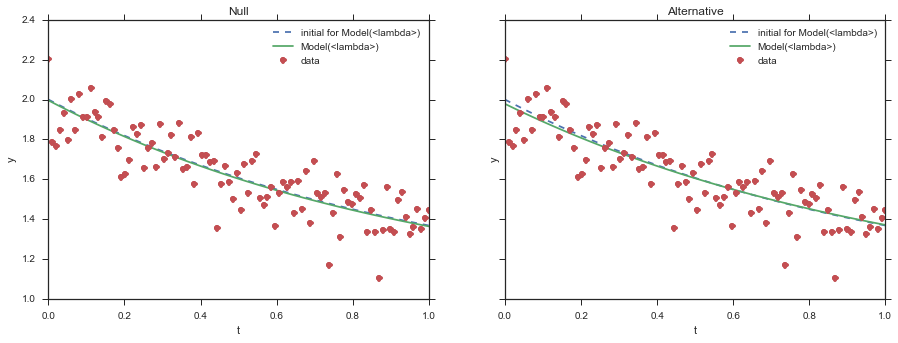

In [4]:
lrt_test(1,1,1,1,False,True)

real: 1 1
H1: {'a': 1.0805491841729526, 'b': 1.0179878804436662}
H0: {'a': 1.0192303572350458, 'b': 1}
pval 0.479031720372 D 0.501066877163 ddf 1


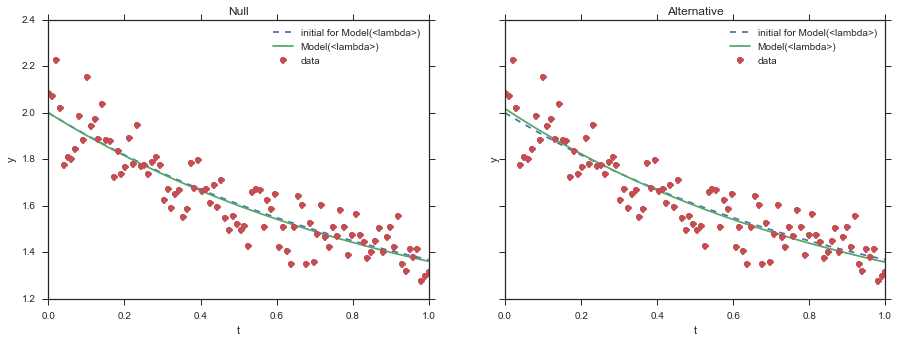

In [5]:
lrt_test(1,1,1,1,True,False)

real: 1 1
H1: {'a': 1.0790736146034272, 'b': 1.0218937717841805}
H0: {'a': -0.56851759361556464, 'b': 0}
pval 7.91549690459e-71 D 316.613904767 ddf 1


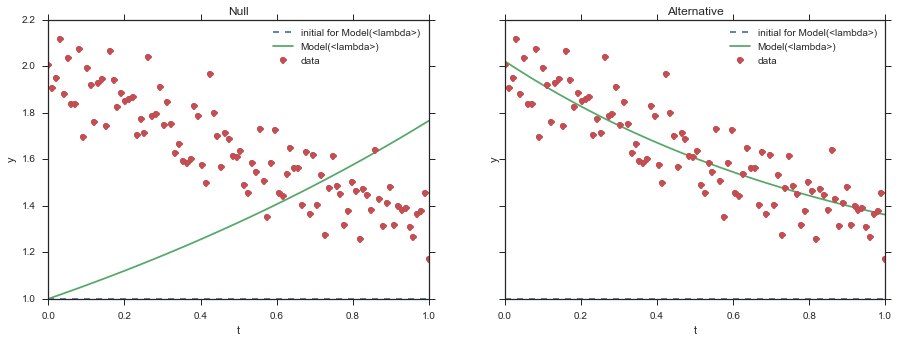

In [6]:
lrt_test(1,1,0,0,True,False)

real: 1 1
H1: {'a': 1.0688809453128842, 'b': 1.0179440615163793}
H0: {'a': 0, 'b': 0.63281825253126589}
pval 1.65956345046e-38 D 168.393764561 ddf 1


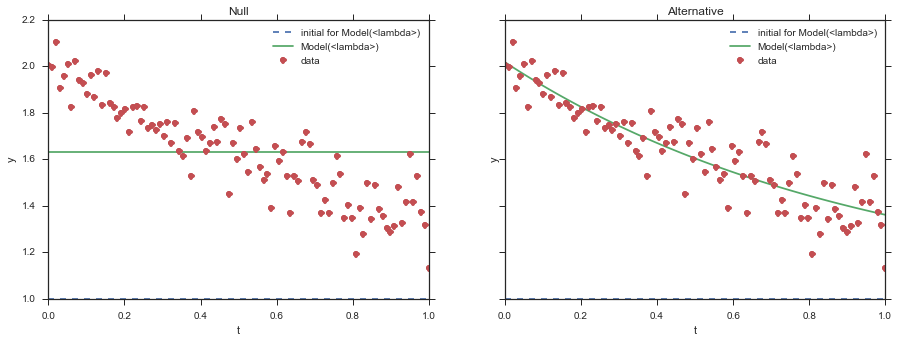

In [7]:
lrt_test(1,1,0,0,False,True)

real: 1 1
H1: {'a': 0.9713270212643671, 'b': 0.99417231411157891}
H0: {'a': 0, 'b': 0.63443627773272793}
pval 1.65411861061e-29 D 127.230394521 ddf 1


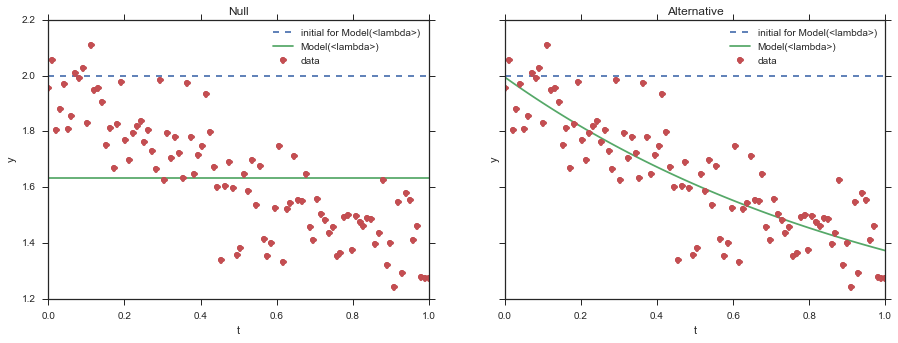

In [8]:
lrt_test(1,1,0,1,False,True)

real: 1 1
H1: {'a': 0.97526880706071484, 'b': 0.98603852959651561}
H0: {'a': 1.0211648319893756, 'b': 1}
pval 0.626046729435 D 0.237459939689 ddf 1


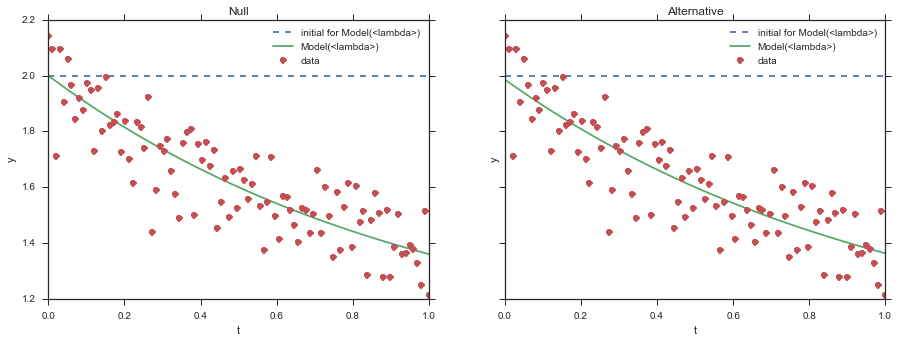

In [9]:
lrt_test(1,1,0,1,True,False)

real: 1 1
H1: {'a': 1.0869432567975494, 'b': 1.0241135901197822}
H0: {'a': -0.57323874617708159, 'b': 0}
pval 2.92429608983e-75 D 336.964204994 ddf 1


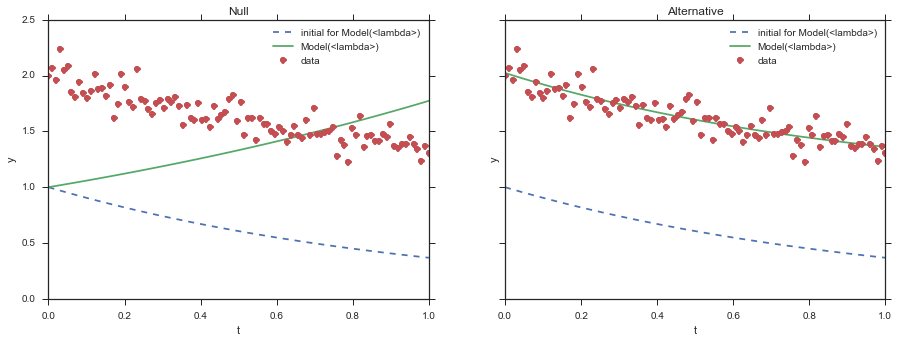

In [10]:
lrt_test(1,1,1,0,True,False)

real: 1 1
H1: {'a': 1.0744449410489705, 'b': 1.0108254084606521}
H0: {'a': 1, 'b': 0.9916523349356362}
pval 0.460175424814 D 0.545467945887 ddf 1


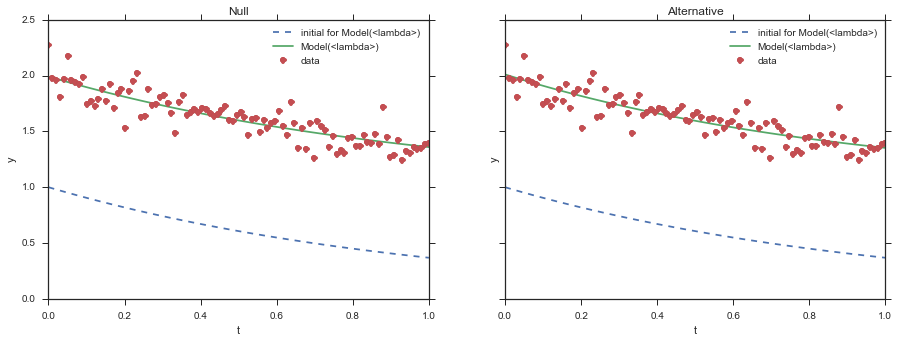

In [11]:
lrt_test(1,1,1,0,False,True)

real: 1 1
H1: {'a': 0.95806242865746261, 'b': 0.97915168579288059}
H0: {'a': 2, 'b': 1.1892859674698684}
pval 5.93198405481e-13 D 51.8693286386 ddf 1


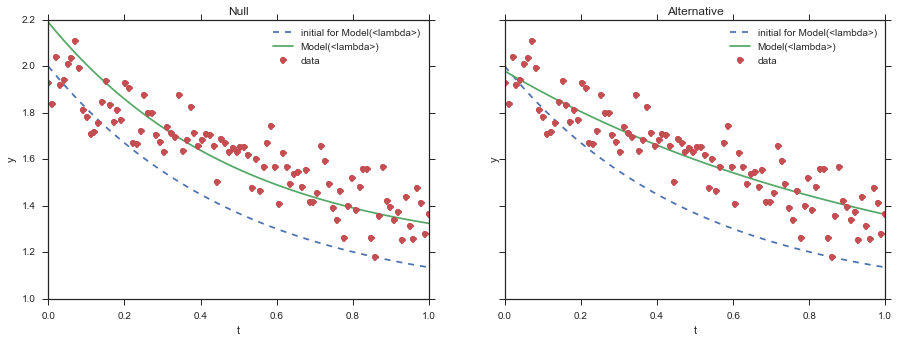

In [14]:
lrt_test(1,1,2,1,False,True)